# import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Packages

import pandas as pd
import numpy as np
import scipy.sparse as sps
import time

%cd /content/drive/My Drive/GitHub/minor-goodbooks-recommender

/content/drive/My Drive/Packages
/content/drive/My Drive/GitHub/minor-goodbooks-recommender


In [3]:
ratings = pd.read_csv('data/ratings.csv')
ratings
##too big!

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [4]:
ratings.user_id.nunique()

53424

In [5]:
def sparsity(df):
  return len(df) / (df.user_id.nunique() * df.book_id.nunique())

sparsity(ratings)

0.011186880428271938

In [471]:
from sklearn.model_selection import train_test_split
_, random_users = train_test_split(ratings.user_id.unique(), test_size = 0.05, random_state = 322)

ratings_random = ratings.loc[ratings['user_id'].isin(random_users)]
ratings_random

,user_id,book_id,rating
629,58,26,1
630,58,58,4
631,58,18,5
632,58,14,3
633,58,2,3
...,...,...,...
5976331,17635,1922,5
5976455,10622,6810,4
5976457,10622,610,5
5976458,53358,253,5


In [7]:
sparsity(ratings_random)

0.011170451889014762

In [8]:
ratings_random.to_csv('data/ratings_random.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51cc5a6b50>]],
      dtype=object)

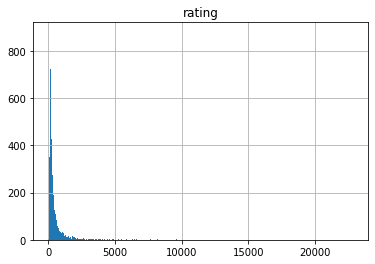

In [9]:
ratings.groupby('book_id').aggregate({'rating' : 'count'}).hist(bins=1000)

In [118]:
ratings_train, ratings_test = train_test_split(ratings_random, test_size = 0.2, random_state = 322)

# surprise

In [11]:
!pip install surprise

     |████████████████████████████████| 11.8MB 17.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617566 sha256=9ff4869673c1924f844a665949d48e1ffe46319c4f94639edf9a882e0d9b12de
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [12]:
%cd /content/drive/My Drive/Packages

from surprise import Reader, Dataset
from surprise.model_selection import KFold, GridSearchCV
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise import NormalPredictor, KNNWithMeans, KNNWithZScore, SVD, SVDpp

%cd /content/drive/My Drive/GitHub/minor-goodbooks-recommender

/content/drive/My Drive/Packages
/content/drive/My Drive/GitHub/minor-goodbooks-recommender


In [13]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_random, reader)

In [14]:
data_train, data_test = Dataset.load_from_df(ratings_train, reader).build_full_trainset(), Dataset.load_from_df(ratings_test, reader)

In [15]:
data_full = Dataset.load_from_df(ratings_random, reader).build_full_trainset()

In [16]:
#from surprise.model_selection.split import train_test_split as surprise_train_test_split
#data_train, data_test = surprise_train_test_split(data)

In [17]:
kf = KFold(n_splits=5, random_state = 322)

In [18]:
def cross_val_score(estimator, X, scoring=None, cv=None):
  cvres_random = cross_validate(estimator, X, cv=cv, measures = [scoring])
  return cvres_random[f'test_{scoring}']

In [ ]:
alg_random = NormalPredictor()

cross_val_score(alg_random, data, cv=5, scoring = 'rmse').mean()

1.331807934109479

In [ ]:
start = time.time()
alg_knn = KNNWithMeans(k=5, verbose=False)

print(cross_val_score(alg_knn, data, cv=5, scoring = 'rmse').mean())
print(time.time()-start)

0.9174599862505092
56.99207329750061


In [ ]:
start = time.time()

alg_knn_z = KNNWithZScore(k=5, verbose=False)

print(cross_val_score(alg_knn_z, data, cv=5, scoring = 'rmse').mean())
print(time.time()-start)

0.9284487040641028
59.418858766555786


In [ ]:
param_grid = {'k': range(1, 10),
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
                              'user_based': [False, True]},
              'verbose' : [False]
              }

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=kf)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8916482192016723
{'k': 9, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}


In [ ]:
param_grid = {'k': range(1, 10),
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
                              'user_based': [False, True]},
              'verbose' : [False]
              }

gsz = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=kf)
gsz.fit(data)

print(gsz.best_score['rmse'])
print(gsz.best_params['rmse'])

0.8957300167589836
{'k': 9, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}


In [19]:
param_grid_svd = {'n_factors': range(10,110,10),
                  'verbose' : [False]
              }

gssvd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=kf)
gssvd.fit(data)

print(gssvd.best_score['rmse'])
print(gssvd.best_params['rmse'])

0.8682623628854061
{'n_factors': 20, 'verbose': False}


In [ ]:
param_grid_svdpp = {'n_factors': range(10,50,4),
                  'verbose' : [False]
              }

gssvdpp = GridSearchCV(SVDpp, param_grid_svdpp, measures=['rmse'], cv=kf)
gssvdpp.fit(data)

print(gssvdpp.best_score['rmse'])
print(gssvdpp.best_params['rmse'])

# recall presision

In [ ]:
def predcit_list(algo, user_id, n=5, verbose=False):
  start = time.time()
  data_pred = data.build_full_trainset()
  algo.fit(data_pred)

  recs = pd.DataFrame({'book_id' : [], 'predicted_rating' : []})
  for id in ratings_random.book_id.unique():
    rat = algo.predict(user_id, id).est
    #print(rat)
    recs = recs.append({'book_id' : id, 'predicted_rating' : rat}, ignore_index=True)
    #print(recs)

  result = recs.loc[~recs['book_id'].isin(ratings_random.loc[ratings_random['user_id']==user_id].book_id)].sort_values('predicted_rating', ascending = False)
  if verbose == True:
    print('Seconds: ', time.time()-start)
  return result

In [ ]:
def recommend_list(user_ratings, ratings_data, algorithm, k=10, verbose = False, remove_rated = True):
  start = time.time()

  reader = Reader(rating_scale=(1, 5))
  data = Dataset.load_from_df(ratings_data, reader)
  data_full = Dataset.load_from_df(ratings_data.append(user_ratings), reader).build_full_trainset()

  algorithm.fit(data_full)

  preds = []
  for i in range(1, 9901):
    preds.append(algorithm.predict(user_ratings.user_id.unique()[0], i).est)
  
  recs = pd.DataFrame({'book_id' : range(1,9901), 'estimated_rating' : preds})
  if remove_rated:
    recs = recs.loc[~recs['book_id'].isin(user_ratings['book_id'])]
  recs = recs.sort_values('estimated_rating', ascending = False).head(k)
  if verbose:
    print('Seconds: ', time.time()-start)

  return recs

In [ ]:
algo_test = KNNWithMeans(k=9, verbose=False)
recommend_list(ratings.loc[ratings['user_id']==1], ratings_random, algo_test, verbose=True, remove_rated=False)

In [ ]:
algo_test = SVD(n_factors=20, verbose=False)
recommend_list(ratings.loc[ratings['user_id']==1], ratings_random, algo_test, verbose=True, remove_rated=False)

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    from collections import defaultdict
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
def precision_at_k(rec_list, )

In [ ]:
algo = KNNWithMeans(k=9, verbose=False)

algo.fit(data_train)
predictions = algo.test(data_test)
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)

print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

In [ ]:
algo_svd = SVD(n_factors=20, verbose=False)

algo_svd.fit(data_train)
predictions = algo_svd.test(data_test)
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

# spotlight

In [489]:
!pip install git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight

  Cloning https://github.com/maciejkula/spotlight.git (to revision master) to /tmp/pip-install-vx4wvgzg/spotlight
  Running command git clone -q https://github.com/maciejkula/spotlight.git /tmp/pip-install-vx4wvgzg/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp37-none-any.whl size=33921 sha256=5f68efd97db0b7b80889fb63c1086510c2e95bf44fe883b80b0819ef455ea7a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-4bk4q3qb/wheels/de/0f/85/71b17c59d32cb9d29c31d4ffb16eb14f4cc153f1e28c7a3efb
Successfully built spotlight
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurre

In [ ]:
import torch
import spotlight

In [ ]:
from spotlight.interactions import Interactions

data = Interactions(*[np.array(i) for _, i in ratings_random.items()])
data_train = Interactions(*[np.array(i) for _, i in ratings_train.items()])
data_test = Interactions(*[np.array(i) for _, i in ratings_test.items()])

In [ ]:
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel

model = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim=128,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   l2=1e-9,  # strength of L2 regularization
                                   learning_rate=1e-3,
                                   use_cuda=torch.cuda.is_available())
model.fit(data_train, verbose=True)

rmse_score(model, data_test)

Epoch 0: loss 13.886664521540695
Epoch 1: loss 3.418573094539888
Epoch 2: loss 1.1470414896379724
Epoch 3: loss 0.8211444383527077
Epoch 4: loss 0.7350682071350163
Epoch 5: loss 0.6972380533750476
Epoch 6: loss 0.6719108909496422
Epoch 7: loss 0.6488575676991705
Epoch 8: loss 0.6267038788406634
Epoch 9: loss 0.6040727829984329


0.86410011960886

In [ ]:
param_grid = {'embedding_dim': np.logspace(1,10, num=10, base=2),
              'n_iter' : range(5,20)}

In [ ]:
np.logspace(1,10, num=10, base=2)

array([   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.,  512.,
       1024.])

In [ ]:
for i in np.logspace(1,10, num=10, base=2):
  k = int(i)
  model = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim=64,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=k,  # minibatch size
                                   l2=1e-9,  # strength of L2 regularization
                                   learning_rate=1e-3,
                                   use_cuda=torch.cuda.is_available())
  model.fit(data_train, verbose=False)

  print(i, rmse_score(model, data_test))

KeyboardInterrupt: ignored

In [ ]:
pred = model.predict(user_ids = 58)

In [ ]:
ratings_random.loc[ratings_random['user_id']==58].book_id

629          26
630          58
631          18
632          14
633           2
           ... 
5771155     279
5785098      61
5811024     702
5830792    9356
5853023    4576
Name: book_id, Length: 82, dtype: int64

In [ ]:
pred_list = pd.DataFrame(enumerate(pred), columns = ['book_id', 'predcited_rating'])
pred_list.loc[~pred_list['book_id'].isin(ratings_random.loc[ratings_random['user_id']==58].book_id)].sort_values(ascending=False, by = 'predcited_rating').head(10)

,book_id,predcited_rating
7593,7593,5.120577
8580,8580,4.996542
5529,5529,4.977715
9004,9004,4.920152
3920,3920,4.866500
7844,7844,4.842587
9566,9566,4.834001
2151,2151,4.804973
9537,9537,4.804045
4620,4620,4.792125


# lightfm

In [ ]:
!pip install lightfm

In [237]:
from scipy.sparse import coo_matrix, csr_matrix

In [486]:
books_map = pd.read_csv('data/books.csv').loc[:, ['id', 'title']].sort_values('id', ascending=True)
#books_titles = books_map.loc[books_map['id'].isin(ratings_random.book_id.unique()), 'title']

In [487]:
book_map.loc[i, 'title']

"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"

In [300]:
def itervalues(df):
  for _, i in df.iterrows():
    yield i.values

In [363]:
from lightfm.data import Dataset

dataset = Dataset()

In [364]:
dataset.fit(ratings_random['user_id'], ratings_random['book_id'])
#dataset.fit_partial(ratings['user_id'], ratings['book_id'])

In [365]:
(interactions, weights) = dataset.build_interactions(itervalues(ratings_random))

In [359]:
weights

<2672x9990 sparse matrix of type '<class 'numpy.float32'>'
	with 298176 stored elements in COOrdinate format>

In [354]:
from lightfm.cross_validation import random_train_test_split
weights_train, weights_test = random_train_test_split(weights, test_percentage=0.2, random_state=322)

In [305]:
data = {'train' : weights_train, 
        'test': weights_test, 
        'item_features' : None, 
        'item_labels' : books_map['title'], 
        'item_feature_labels' : None}

In [306]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='warp')
model.fit(data['train'], epochs=10)

train_precision = precision_at_k(model, data['train'], k=10).mean()
test_precision = precision_at_k(model, data['test'], k=10, train_interactions=data['train']).mean()

train_auc = auc_score(model, data['train']).mean()
test_auc = auc_score(model, data['test'], train_interactions=data['train']).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.41, test 0.17.
AUC: train 0.93, test 0.90.


In [366]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(weights, epochs=10)

In [319]:
def sample_recommendation_original(model, data, user_id, k=10, print_output=True):

  n_users, n_items = data['train'].shape

  known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
  scores = model.predict(user_id, np.arange(n_items))
  top_items = data['item_labels'][np.argsort(-scores)]
  if print_output == True:
    for x in known_positives[:k]:
      print("        %s" % x)
    print("     Recommended:")
    for x in top_items[:k]:
      print("        %s" % x)

In [320]:
sample_recommendation_original(model, data, 0)

        The Hunger Games (The Hunger Games, #1)
        Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
        Twilight (Twilight, #1)
        To Kill a Mockingbird
        The Fault in Our Stars
        The Hobbit
        The Catcher in the Rye
        Angels & Demons  (Robert Langdon, #1)
        Pride and Prejudice
        The Kite Runner
     Recommended:
        The Giver (The Giver, #1)
        Memoirs of a Geisha
        The Hobbit
        To Kill a Mockingbird
        Divine Secrets of the Ya-Ya Sisterhood
        Like Water for Chocolate
        The Catcher in the Rye
        Angela's Ashes (Frank McCourt, #1)
        Siddhartha
        Life of Pi


In [ ]:
model.fit_partial()

In [443]:
def fetch_user_ratings_id(user_id):
  pd.options.mode.chained_assignment = None
  user_ratings = ratings.loc[ratings['user_id']==user_id, :]
  user_ratings['user_id'] = 999999
  return user_ratings

In [475]:
dataset = Dataset()
dataset.fit(np.append(ratings_random['user_id'].unique(), 999999), range(1,10001))

In [476]:
dataset

In [477]:
(interactions, weights) = dataset.build_interactions(itervalues(ratings_random))

In [478]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(weights, epochs=10)

In [ ]:
def setup_lightfm(ratings_data):
  from lightfm import LightFM, Dataset

  dataset = Dataset()
  dataset.fit(np.append(ratings_data['user_id'].unique(), 999999), range(1,10001))

  (interactions, weights) = dataset.build_interactions(itervalues(ratings_data))

  model = LightFM(learning_rate=0.05, loss='warp')
  model.fit(weights, epochs=10)

  return dataset, model

In [494]:
def recommend_list_lightfm(user_ratings, ratings_data, algorithm, verbose = False, remove_rated = True):
  import copy
  dataset_local = copy.deepcopy(dataset)

  def itervalues(df):
    for _, i in df.iterrows():
      yield i.values

  (new_interactions, new_weights) = dataset_local.build_interactions(itervalues(ratings_data.append(user_ratings)))

  algorithm_local = copy.deepcopy(algorithm)
  algorithm_local.fit_partial(new_weights)

  data = {'train' : new_weights, 
          'item_features' : None, 
          'item_labels' : books_map['title'], 
          'item_feature_labels' : None}

  n_users, n_items = data['train'].shape
  user_id = n_users-1

  known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
  scores = algorithm_local.predict(user_id, np.arange(n_items))
  top_items = data['item_labels'][np.argsort(-scores)]

  if remove_rated:
    return [i for i in top_items if i not in known_positives][:10]
  else:
    return top_items[:10]

In [ ]:
#(user_ratings, ratings_data, algorithm, verbose = False, remove_rated = True):

In [480]:
print(dataset, model)

<lightfm.data.Dataset object at 0x7f517da2d590> <lightfm.lightfm.LightFM object at 0x7f517da27450>


In [495]:
recommend_list_lightfm(fetch_user_ratings_id(4), ratings_random, model)

['To Kill a Mockingbird',
 'The Great Gatsby',
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
 'Animal Farm',
 '1984',
 'The Catcher in the Rye',
 'The Hobbit',
 'Angels & Demons  (Robert Langdon, #1)',
 'Romeo and Juliet',
 'The Hunger Games (The Hunger Games, #1)']

In [470]:
print(dataset, model)

<lightfm.data.Dataset object at 0x7f517dab8fd0> <lightfm.lightfm.LightFM object at 0x7f517da27bd0>


In [468]:
fetch_user_ratings_id(3)

,user_id,book_id,rating
71490,999999,8452,1
71491,999999,522,1
71492,999999,4788,2
71493,999999,150,2
71494,999999,9962,1
...,...,...,...
342371,999999,4090,5
493529,999999,32,2
493748,999999,58,2
493749,999999,15,3
